# How does digest2 improve over LSST?

In this notebook we explain how digest2 improves over the course of LSST as objects are identified.

You can find code for creating Figure 7.

In [1]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

In [4]:
import pandas as pd

import astropy.coordinates as coord
from astropy.coordinates import SkyCoord
from astropy.time import Time
import astropy.units as u

%config InlineBackend.figure_format = "retina"

from datetime import date

import numpy as np
from os import listdir

import matplotlib.pyplot as plt
from matplotlib.patches import Patch

import sys
sys.path.append("../mitigation_algorithm")
import helpers

import difi

In [5]:
%config InlineBackend.figure_format = 'retina'

plt.rc('font', family='serif')
plt.rcParams['text.usetex'] = False
fs = 24

# update various fontsizes to match
params = {'figure.figsize': (12, 8),
          'legend.fontsize': fs,
          'axes.labelsize': fs,
          'xtick.labelsize': 0.6 * fs,
          'ytick.labelsize': 0.6 * fs,
          'axes.linewidth': 1.1,
          'xtick.major.size': 7,
          'xtick.minor.size': 4,
          'ytick.major.size': 7,
          'ytick.minor.size': 4}
plt.rcParams.update(params)

In [6]:
s3m = pd.read_hdf("../../hybrid-sso-catalogs/catalogues/s3m_initial.h5")
hex_ids = np.array(['{:07X}'.format(num) for num in np.arange(len(s3m.index.values))])
s3m_to_hex7 = dict(zip(s3m.index.values, hex_ids))

In [7]:
hex7_to_s3m = dict(zip(hex_ids, s3m.index.values))

In [8]:
s3m_to_hex7_bytes = dict(zip(s3m.index.values.astype("|S32"), hex_ids))

In [9]:
f2n = [[0, 1, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19],
       [19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31],
       [31, 35, 36, 37, 39, 40, 41, 42, 43, 44, 45, 46],
       [46, 47, 49, 50, 52, 53, 54, 56, 57, 58, 59, 60, 61],
       [61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72],
       [72, 73, 74, 75, 76, 77, 78, 79, 82, 83, 85, 86, 87, 88, 89],
       [89, 90, 91, 93, 94, 95, 98, 107, 108, 109, 110, 111, 112],
       [112, 113, 114, 115, 118, 119, 121, 122, 124, 128, 129, 130, 131, 132],
       [132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144],
       [144, 145, 146, 147, 148, 149, 150, 151, 152, 154, 157, 159],
       [159, 160, 161, 162, 163, 165, 166, 167, 168, 169, 170, 171],
       [171, 172, 173, 174, 175, 178, 179, 180, 181, 182, 183, 184, 185],
       [185, 186, 187, 188, 191, 192, 193, 196, 197, 198, 199, 200, 201, 202],
       [202, 203, 204, 205, 214, 215, 216, 217, 218, 219, 220, 221, 222, 223, 224],
       [224, 225, 226, 227, 228, 229, 230, 231, 232, 234, 235, 236, 237, 238, 239],
       [239, 240, 242, 243, 244, 245, 246, 247, 255, 256, 257, 258, 259, 260],
       [260, 261, 262, 263, 264, 265, 266, 267, 268, 269, 270, 271, 272, 273, 274, 275],
       [275, 276, 277, 278, 279, 280, 281, 282, 283, 284, 285, 286, 287, 288, 289],
       [289, 290, 291, 292, 293, 294, 295, 296, 297, 298, 299, 303, 304, 305, 306, 307, 308],
       [308, 309, 310, 311, 312, 313, 314, 315, 316, 317, 318, 319, 320, 321, 322],
       [322, 323, 324, 325, 326, 327, 328, 329, 330, 331, 332, 333, 334, 335, 336, 337],
       [337, 338, 339, 340, 341, 342, 343, 344, 345, 346, 347, 348, 349, 350],
       [350, 351, 352, 353, 354, 355, 356, 358, 359, 361, 362, 363, 364, 365],
       [365, 366, 367, 368, 369, 370, 371, 372, 373, 374, 375, 376, 377],
       [377, 378, 379, 380, 382, 383, 386, 387, 388, 389, 390, 391, 392, 393],
       [393, 394, 395, 396, 397, 398, 399, 400, 401, 402, 403, 404],
       [404, 405, 406, 407, 408, 409, 410, 411, 412, 413, 414, 415, 416],
       [416, 417, 418, 419, 420, 421, 422, 423, 424, 425, 426],
       [426, 427, 428, 429, 430, 431, 432, 433, 434, 437, 438, 439],
       [439, 444, 445, 446, 448, 456, 457, 461, 462, 463, 472, 474, 479, 480, 481],
       [481, 482, 483, 484, 485, 486, 487, 488, 489, 490, 491, 492, 498],
       [498, 499, 500, 501, 502, 503, 504, 506, 508, 509, 510, 514, 515, 519, 520, 521, 522],
       [522, 523, 524, 525, 526, 527, 529, 530, 536, 537, 539, 540, 541, 542, 543, 544],
       [544, 545, 546, 549, 554, 555, 556, 557, 558, 559, 560, 561, 562, 563, 564, 565],
       [565, 567, 568, 569, 570, 571, 572, 573, 575, 576, 577, 578, 579, 582, 583, 584, 585, 586, 588],
       [588, 589, 590, 593, 594, 595, 597, 598, 599, 600, 601, 602, 603, 604, 605, 606],
       [606, 607, 608, 609, 610, 612, 621, 622, 623, 624, 625, 626, 628, 629, 630, 631],
       [631, 632, 634, 635, 636, 637, 638, 639, 640, 641, 642, 643, 644, 645, 646],
       [646, 647, 648, 651, 652, 653, 654, 655, 656, 657, 658, 661, 662, 663, 664, 665, 666],
       [666, 667, 668, 670, 671, 672, 673, 674, 675, 676, 677, 678, 679, 680, 681, 682],
       [682, 683, 684, 685, 686, 687, 688, 689, 690, 691, 692, 693, 695, 696, 697, 698],
       [698, 699, 700, 701, 702, 707, 710, 711, 712, 713, 714, 715, 716, 717, 718],
       [718, 720, 721, 722, 723, 725, 726, 727, 728, 729, 730, 731, 732, 733, 734],
       [734, 736, 737, 741, 743, 744, 746, 747, 749, 750, 751, 753, 754, 755, 756, 757, 758, 759],
       [759, 760, 761, 762, 763, 765, 774, 775, 776, 777, 781, 782, 784],
       [784, 786, 787, 789, 792, 793, 803, 804, 805, 806, 807, 808],
       [808, 815, 818, 819, 821, 822, 823, 824, 825, 826, 827, 828, 843, 844, 845],
       [845, 846, 847, 848, 851, 852, 853, 854, 855, 857, 858, 859],
       [859, 860, 861, 862, 863, 864, 866, 867, 868, 869],
       [869, 870, 871, 872, 873, 875, 876, 877, 878, 879, 881, 882, 885, 886, 887],
       [887, 888, 889, 890, 891, 893, 895, 896, 897, 898, 899, 900, 901, 902, 903],
       [903, 904, 905, 906, 907, 908, 909, 910, 911, 914, 915, 916, 917],
       [917, 918, 919, 920, 921, 922, 925, 926, 927, 928, 930, 931, 932, 933, 934, 935],
       [935, 936, 937, 938, 939, 940, 941, 943, 944, 945, 946, 947, 948, 949, 950, 951],
       [951, 952, 953, 954, 955, 956, 957, 958, 959, 960, 961, 962, 963, 964, 965],
       [965, 966, 967, 968, 969, 970, 971, 972, 973, 974, 975, 976, 977, 980, 982],
       [982, 983, 984, 985, 986, 987, 988, 989, 990, 991, 992, 993, 994, 995, 999],
       [999, 1000, 1001, 1002, 1003, 1004, 1005, 1006, 1007, 1008, 1009, 1010, 1011, 1012, 1013],
       [1013, 1017, 1018, 1019, 1020, 1021, 1023, 1024, 1025, 1026, 1027, 1028, 1029, 1030, 1031, 1032, 1033, 1034, 1035],
       [1035, 1036, 1037, 1039, 1040, 1041, 1042, 1043, 1044, 1045, 1046, 1047, 1048, 1049, 1050, 1052],
       [1052, 1053, 1054, 1055, 1056, 1057, 1058, 1059, 1060, 1061, 1062, 1063, 1064, 1065, 1066, 1067],
       [1067, 1068, 1069, 1070, 1071, 1072, 1073, 1074, 1075, 1076, 1077, 1078, 1079, 1080, 1081],
       [1081, 1082, 1083, 1084, 1085, 1086, 1088, 1089, 1090, 1091, 1092, 1093, 1094],
       [1094, 1095, 1096, 1097, 1098, 1099, 1100, 1101, 1102, 1103, 1104, 1105, 1107, 1108],
       [1108, 1109, 1110, 1111, 1112, 1113, 1114, 1115, 1116, 1117, 1118, 1119],
       [1119, 1120, 1121, 1122, 1123, 1124, 1127, 1129, 1130, 1131, 1132, 1133, 1135],
       [1135, 1136, 1137, 1138, 1139, 1140, 1141, 1142, 1143, 1144, 1150, 1151, 1152],
       [1152, 1153, 1154, 1155, 1156, 1157, 1158, 1160, 1161, 1162, 1164, 1165, 1166, 1167],
       [1167, 1168, 1169, 1170, 1171, 1172, 1173, 1174, 1175, 1176, 1177],
       [1177, 1179, 1183, 1184, 1185, 1186, 1187, 1188, 1189, 1190, 1191, 1192, 1209, 1210, 1211, 1212, 1220],
       [1220, 1221, 1222, 1223, 1224, 1225, 1228, 1230, 1231, 1232, 1233, 1234, 1236],
       [1236, 1237, 1238, 1239, 1240, 1241, 1242, 1243, 1245, 1246, 1247, 1248, 1249],
       [1249, 1250, 1251, 1252, 1254, 1255, 1256, 1257, 1258, 1259, 1260, 1261],
       [1261, 1263, 1264, 1266, 1267, 1268, 1269, 1271, 1272, 1273, 1274, 1287, 1288, 1289],
       [1289, 1290, 1292, 1293, 1294, 1295, 1296, 1297, 1298, 1299, 1300, 1301, 1304],
       [1305, 1306, 1310, 1311, 1313, 1315, 1316, 1318, 1319, 1320, 1321, 1322, 1323, 1324, 1325, 1326, 1327],
       [1327, 1328, 1329, 1332, 1333, 1334, 1335, 1336, 1337, 1338, 1339, 1340, 1341, 1350, 1351],
       [1351, 1352, 1353, 1354, 1355, 1356, 1357, 1358, 1359, 1360, 1361, 1362, 1363, 1364, 1365],
       [1365, 1366, 1367, 1368, 1369, 1370, 1371, 1372, 1373, 1374, 1375, 1376, 1377, 1378, 1379, 1380],
       [1380, 1381, 1382, 1383, 1384, 1385, 1386, 1390, 1391, 1392, 1393, 1394, 1395, 1396, 1397, 1398, 1399],
       [1399, 1400, 1401, 1402, 1403, 1404, 1405, 1406, 1407, 1408, 1409, 1410, 1411, 1412, 1414, 1416],
       [1416, 1417, 1418, 1419, 1420, 1421, 1422, 1423, 1424, 1425, 1426, 1427, 1428, 1429, 1430, 1431],
       [1431, 1432, 1433, 1434, 1435, 1436, 1437, 1438, 1439, 1441, 1442, 1443, 1444, 1445],
       [1445, 1446, 1447, 1448, 1449, 1451, 1452, 1453, 1454, 1455, 1456, 1457, 1458, 1459, 1460, 1461],
       [1461, 1462, 1463, 1464, 1465, 1466, 1467, 1468, 1469, 1470, 1471, 1473, 1474],
       [1474, 1475, 1476, 1477, 1478, 1479, 1480, 1481, 1482, 1483, 1484, 1485, 1486],
       [1486, 1487, 1488, 1489, 1490, 1491, 1493, 1494, 1495, 1496, 1497, 1498, 1499, 1500],
       [1500, 1501, 1507, 1508, 1509, 1510, 1511, 1513, 1514, 1515, 1516, 1517, 1518],
       [1518, 1519, 1520, 1521, 1522, 1523, 1524, 1525, 1526, 1527, 1528, 1529, 1530],
       [1530, 1531, 1532, 1535, 1536, 1537, 1538, 1539, 1542, 1543, 1547, 1548],
       [1548, 1549, 1551, 1552, 1553, 1554, 1555, 1556, 1557, 1558, 1573, 1579, 1580],
       [1580, 1581, 1582, 1583, 1584, 1585, 1586, 1587, 1592, 1593, 1594, 1595],
       [1595, 1596, 1597, 1598, 1599, 1600, 1603, 1604, 1605, 1606, 1607, 1608],
       [1608, 1609, 1610, 1611, 1612, 1613, 1614, 1615, 1616, 1617, 1618],
       [1618, 1619, 1620, 1621, 1622, 1623, 1624, 1626, 1627, 1628, 1629, 1630],
       [1630, 1632, 1634, 1635, 1636, 1637, 1638, 1639, 1640, 1641, 1643, 1644, 1645, 1646, 1647, 1648],
       [1648, 1650, 1657, 1658, 1659, 1661, 1663, 1664, 1665, 1666, 1667, 1668, 1669, 1670, 1671],
       [1671, 1672, 1673, 1674, 1675, 1676, 1677, 1678, 1679, 1680, 1681, 1682, 1683, 1684],
       [1684, 1685, 1687, 1688, 1689, 1690, 1691, 1692, 1693, 1694, 1695, 1697, 1698, 1699, 1702, 1706, 1709],
       [1709, 1712, 1713, 1715, 1716, 1718, 1719, 1720, 1721, 1722, 1723, 1724, 1725, 1726, 1727, 1728],
       [1728, 1729, 1730, 1731, 1732, 1733, 1734, 1735, 1736, 1737, 1738, 1739, 1740, 1741, 1742],
       [1742, 1743, 1744, 1745, 1746, 1747, 1748, 1749, 1750, 1751, 1752, 1753, 1754, 1755, 1756, 1757, 1758, 1759],
       [1759, 1760, 1761, 1762, 1764, 1765, 1766, 1767, 1768, 1769, 1770, 1771, 1772, 1773, 1774, 1775, 1776],
       [1776, 1777, 1778, 1779, 1780, 1781, 1782, 1783, 1784, 1785, 1786, 1787, 1788, 1789, 1790, 1791],
       [1791, 1792, 1793, 1794, 1795, 1796, 1797, 1798, 1799, 1800, 1801, 1802, 1803, 1804, 1805],
       [1805, 1807, 1808, 1809, 1810, 1811, 1812, 1813, 1814, 1818, 1819, 1820, 1821, 1822],
       [1822, 1823, 1824, 1825, 1826, 1828, 1829, 1830, 1831, 1832, 1833, 1834, 1835, 1836, 1837],
       [1837, 1838, 1839, 1840, 1841, 1842, 1843, 1846, 1847, 1848, 1849, 1850, 1851],
       [1851, 1852, 1853, 1855, 1858, 1859, 1860, 1861, 1862, 1863, 1864, 1865, 1868, 1869],
       [1869, 1870, 1871, 1872, 1873, 1874, 1875, 1876, 1878, 1879, 1880, 1881],
       [1881, 1882, 1883, 1885, 1886, 1887, 1888, 1889, 1890, 1891, 1892],
       [1892, 1893, 1894, 1895, 1896, 1897, 1900, 1901, 1902, 1903, 1904, 1907, 1908, 1912],
       [1912, 1913, 1914, 1916, 1918, 1919, 1920, 1921, 1922, 1923, 1931, 1932, 1933, 1934],
       [1934, 1935, 1936, 1937, 1939, 1940, 1941, 1942, 1943, 1945, 1946, 1948],
       [1948, 1949, 1950, 1952, 1954, 1956, 1957, 1958, 1959, 1960, 1961, 1966, 1967, 1968, 1969, 1970],
       [1970, 1971, 1972, 1973, 1978, 1979, 1980, 1982, 1983, 1984, 1985, 1986, 1987],
       [1987, 1988, 1989, 1990, 1995, 1996, 1997, 1998, 1999, 2000, 2005, 2006, 2009, 2010],
       [2010, 2011, 2012, 2013, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2023, 2024, 2025, 2026],
       [2026, 2027, 2028, 2029, 2033, 2034, 2035, 2038, 2039, 2040, 2041, 2042, 2043, 2044, 2045],
       [2045, 2046, 2054, 2055, 2056, 2057, 2058, 2059, 2061, 2062, 2065, 2066, 2067, 2068, 2069, 2070, 2071],
       [2071, 2072, 2080, 2081, 2082, 2083, 2084, 2085, 2086, 2087, 2088, 2089, 2090, 2091, 2092, 2094],
       [2094, 2095, 2096, 2097, 2098, 2099, 2100, 2101, 2102, 2103, 2104, 2105, 2106, 2107, 2108, 2109],
       [2109, 2110, 2111, 2112, 2113, 2114, 2115, 2116, 2117, 2118, 2119, 2120, 2121, 2124, 2125, 2126, 2127],
       [2127, 2128, 2129, 2130, 2131, 2132, 2147, 2148, 2149, 2150, 2151, 2152, 2153, 2154, 2155],
       [2155, 2156, 2157, 2158, 2159, 2160, 2161, 2162, 2163, 2164, 2165, 2166, 2167, 2168, 2169],
       [2169, 2170, 2171, 2172, 2173, 2174, 2175, 2176, 2177, 2178, 2179, 2180, 2181, 2182],
       [2182, 2183, 2184, 2185, 2186, 2187, 2188, 2190, 2191, 2192, 2193, 2194, 2195, 2196],
       [2196, 2197, 2198, 2199, 2200, 2201, 2202, 2204, 2205, 2206, 2207, 2208, 2209, 2210],
       [2210, 2211, 2212, 2213, 2214, 2215, 2216, 2217, 2218, 2219, 2220, 2221, 2222],
       [2222, 2223, 2224, 2225, 2226, 2227, 2228, 2230, 2233, 2234, 2235, 2236, 2237, 2238],
       [2238, 2239, 2241, 2243, 2244, 2245, 2246, 2247, 2248, 2249, 2251, 2252, 2254, 2255],
       [2255, 2256, 2257, 2258, 2259, 2260, 2261, 2269, 2270, 2271, 2272, 2279, 2286, 2287],
       [2287, 2288, 2303, 2305, 2307, 2308, 2309, 2311, 2313, 2316, 2317, 2318, 2319, 2320, 2321, 2322],
       [2322, 2323, 2325, 2326, 2328, 2335, 2336, 2337, 2338, 2339, 2340, 2341, 2342],
       [2342, 2343, 2345, 2346, 2347, 2350, 2351, 2352, 2353, 2354, 2355, 2356, 2357, 2361, 2363],
       [2363, 2367, 2370, 2371, 2372, 2373, 2374, 2375, 2377, 2380, 2381, 2383, 2388, 2389, 2390, 2391],
       [2391, 2392, 2393, 2394, 2395, 2396, 2398, 2399, 2401, 2402, 2403, 2406, 2407, 2408],
       [2408, 2409, 2410, 2411, 2412, 2416, 2417, 2418, 2419, 2420, 2425, 2426, 2427, 2428],
       [2428, 2429, 2430, 2431, 2432, 2433, 2434, 2435, 2436, 2437, 2438, 2439, 2440, 2441, 2442, 2443],
       [2443, 2444, 2445, 2446, 2447, 2448, 2449, 2450, 2452, 2453, 2455, 2456, 2457, 2458, 2459, 2460, 2461, 2462, 2463],
       [2463, 2464, 2465, 2466, 2467, 2468, 2469, 2471, 2472, 2473, 2474, 2475, 2476, 2477, 2478, 2479],
       [2479, 2480, 2481, 2482, 2483, 2484, 2486, 2487, 2488, 2489, 2490, 2491, 2492, 2493, 2494, 2495],
       [2495, 2496, 2497, 2498, 2499, 2500, 2501, 2502, 2503, 2504, 2505, 2506, 2507, 2508, 2509, 2510, 2511],
       [2511, 2512, 2513, 2514, 2515, 2516, 2517, 2518, 2519, 2520, 2521, 2522, 2523, 2524, 2525],
       [2525, 2526, 2527, 2528, 2529, 2530, 2531, 2532, 2533, 2534, 2535, 2536, 2537, 2538, 2539],
       [2539, 2540, 2541, 2542, 2543, 2544, 2545, 2547, 2548, 2549, 2551, 2552, 2553, 2554],
       [2554, 2555, 2556, 2557, 2558, 2559, 2560, 2561, 2562, 2563, 2564, 2565, 2566, 2567, 2568],
       [2568, 2569, 2570, 2571, 2572, 2573, 2574, 2575, 2576, 2577, 2578, 2579, 2580, 2581],
       [2581, 2582, 2583, 2584, 2585, 2586, 2587, 2588, 2589, 2590, 2591, 2592],
       [2592, 2593, 2594, 2595, 2596, 2597, 2598, 2602, 2603, 2604, 2605, 2606, 2607],
       [2607, 2608, 2609, 2610, 2611, 2612, 2613, 2614, 2615, 2616, 2618, 2619],
       [2619, 2620, 2621, 2622, 2625, 2630, 2631, 2632, 2633, 2637, 2638, 2639, 2641],
       [2641, 2642, 2643, 2645, 2646, 2647, 2649, 2652, 2663, 2664, 2665, 2666, 2667, 2668],
       [2668, 2669, 2670, 2671, 2672, 2673, 2674, 2675, 2676, 2679, 2684, 2685, 2686, 2687],
       [2687, 2690, 2691, 2692, 2693, 2694, 2695, 2696, 2698, 2699, 2700, 2701, 2702, 2703, 2704],
       [2704, 2705, 2706, 2707, 2708, 2709, 2711, 2712, 2713, 2714, 2715],
       [2715, 2716, 2717, 2718, 2721, 2722, 2723, 2724, 2725, 2727, 2729, 2730, 2731, 2732],
       [2732, 2733, 2734, 2736, 2737, 2738, 2739, 2740, 2741, 2743, 2745, 2746, 2747, 2748, 2749],
       [2749, 2750, 2751, 2752, 2754, 2755, 2756, 2757, 2760, 2761, 2762, 2765, 2766, 2770, 2771, 2772],
       [2772, 2773, 2777, 2778, 2779, 2780, 2781, 2782, 2784, 2785, 2786, 2787, 2788, 2789],
       [2789, 2790, 2792, 2794, 2795, 2796, 2797, 2798, 2799, 2800, 2811, 2812, 2813, 2816, 2817],
       [2817, 2818, 2819, 2820, 2821, 2823, 2825, 2827, 2828, 2830, 2831, 2832, 2833, 2834, 2835, 2836],
       [2836, 2837, 2839, 2840, 2841, 2842, 2843, 2844, 2845, 2846, 2847, 2848, 2849, 2850, 2851, 2852],
       [2852, 2853, 2854, 2855, 2856, 2857, 2858, 2859, 2860, 2861, 2862, 2863, 2864, 2865, 2866, 2867],
       [2867, 2868, 2870, 2871, 2872, 2873, 2875, 2876, 2877, 2878, 2879, 2880, 2881, 2882, 2883],
       [2883, 2884, 2885, 2886, 2887, 2888, 2889, 2890, 2891, 2892, 2893, 2894, 2895, 2896, 2897],
       [2897, 2898, 2899, 2900, 2901, 2902, 2903, 2904, 2905, 2906, 2907, 2908, 2909, 2910, 2911],
       [2911, 2912, 2913, 2914, 2915, 2916, 2918, 2919, 2920, 2921, 2922, 2923, 2924, 2925, 2927],
       [2927, 2928, 2929, 2930, 2931, 2932, 2933, 2934, 2935, 2943, 2944, 2945, 2946, 2948, 2950],
       [2950, 2951, 2952, 2953, 2954, 2955, 2956, 2957, 2958, 2959, 2960, 2961, 2962, 2963],
       [2963, 2964, 2965, 2966, 2967, 2968, 2969, 2970, 2975, 2976, 2977, 2978, 2979],
       [2979, 2980, 2981, 2982, 2983, 2984, 2985, 2986, 2987, 2988, 2991, 2992, 2993],
       [2993, 2994, 2996, 2998, 2999, 3000, 3003, 3004, 3005, 3006, 3007, 3008, 3010],
       [3010, 3011, 3012, 3013, 3014, 3016, 3017, 3018, 3033, 3034, 3036, 3037, 3038],
       [3038, 3039, 3040, 3041, 3042, 3043, 3044, 3048, 3051, 3055, 3056],
       [3056, 3057, 3058, 3059, 3064, 3065, 3066, 3068, 3069, 3070, 3071, 3072, 3073, 3077],
       [3077, 3078, 3080, 3082, 3083, 3084, 3085, 3086, 3092, 3093, 3094, 3095, 3096],
       [3096, 3097, 3099, 3100, 3101, 3102, 3103, 3104, 3105, 3107, 3108, 3109, 3110, 3111, 3112],
       [3112, 3113, 3114, 3115, 3116, 3117, 3118, 3119, 3120, 3122, 3123, 3124, 3125],
       [3125, 3126, 3127, 3128, 3129, 3130, 3131, 3132, 3133, 3135, 3136, 3137, 3138, 3139, 3140, 3141, 3142, 3143, 3144],
       [3144, 3145, 3147, 3148, 3149, 3150, 3152, 3153, 3154, 3155, 3156, 3157, 3159, 3160, 3161, 3162],
       [3162, 3163, 3164, 3165, 3168, 3169, 3173, 3177, 3178, 3179, 3180, 3181, 3182, 3183, 3184, 3187, 3188, 3189],
       [3189, 3190, 3191, 3192, 3193, 3194, 3195, 3196, 3197, 3198, 3199, 3200, 3201, 3202, 3203, 3205, 3207, 3208, 3209, 3210],
       [3210, 3211, 3212, 3213, 3214, 3215, 3216, 3217, 3218, 3219, 3220, 3223, 3224, 3225, 3226, 3227],
       [3227, 3228, 3229, 3230, 3231, 3232, 3233, 3234, 3235, 3236, 3237, 3239, 3240, 3241, 3242, 3243, 3244, 3245],
       [3245, 3247, 3248, 3249, 3250, 3251, 3252, 3253, 3254, 3255, 3256, 3257, 3258, 3259, 3260, 3261, 3262],
       [3262, 3263, 3264, 3265, 3266, 3268, 3269, 3270, 3271, 3272, 3273, 3274, 3276, 3278, 3279, 3280],
       [3280, 3281, 3282, 3284, 3285, 3286, 3287, 3288, 3289, 3290, 3292, 3293, 3294, 3296, 3297],
       [3297, 3298, 3299, 3300, 3301, 3302, 3303, 3304, 3306, 3307, 3308, 3309],
       [3309, 3310, 3311, 3312, 3313, 3314, 3315, 3316, 3317, 3318, 3319, 3320, 3321],
       [3321, 3322, 3323, 3324, 3325, 3329, 3330, 3331, 3332, 3333, 3334, 3335, 3337, 3338],
       [3338, 3340, 3343, 3344, 3345, 3346, 3349, 3350, 3351, 3353, 3356, 3357, 3360, 3362, 3363, 3364, 3365],
       [3365, 3366, 3369, 3371, 3374, 3375, 3376, 3377, 3379, 3380, 3381, 3382, 3392],
       [3392, 3397, 3398, 3401, 3407, 3408, 3409, 3410, 3412, 3414, 3415, 3416, 3417, 3418],
       [3418, 3422, 3423, 3424, 3426, 3427, 3428, 3429, 3430, 3431, 3432, 3433, 3434, 3436, 3437, 3439],
       [3439, 3440, 3441, 3443, 3444, 3445, 3446, 3447, 3449, 3452, 3453, 3455, 3456, 3457],
       [3457, 3460, 3461, 3462, 3463, 3468, 3469, 3471, 3472, 3473, 3474, 3475, 3476, 3478, 3479],
       [3479, 3482, 3483, 3484, 3485, 3486, 3487, 3488, 3490, 3492, 3493, 3494, 3495, 3496, 3497, 3498],
       [3498, 3500, 3501, 3503, 3504, 3505, 3506, 3507, 3508, 3510, 3511, 3512, 3513, 3514, 3515, 3516, 3517],
       [3517, 3518, 3519, 3520, 3522, 3523, 3524, 3525, 3526, 3527, 3528, 3529, 3530, 3531, 3532],
       [3532, 3540, 3541, 3542, 3543, 3544, 3546, 3547, 3548, 3550, 3551, 3552, 3553, 3554, 3555],
       [3555, 3556, 3557, 3558, 3559, 3560, 3561, 3562, 3563, 3564, 3565, 3566, 3567, 3568, 3569],
       [3569, 3570, 3571, 3572, 3573, 3574, 3575, 3576, 3577, 3578, 3579, 3580, 3581, 3582, 3583, 3584],
       [3584, 3585, 3586, 3587, 3588, 3589, 3590, 3591, 3592, 3593, 3594, 3595, 3596, 3597, 3598, 3602],
       [3602, 3603, 3604, 3605, 3606, 3607, 3608, 3609, 3610, 3611, 3612, 3613, 3614, 3615, 3616],
       [3616, 3617, 3618, 3619, 3620, 3621, 3622, 3623, 3624, 3625, 3626, 3628, 3629, 3630, 3631],
       [3631, 3632, 3633, 3634, 3635, 3636, 3637, 3639, 3640, 3641, 3642, 3643, 3644, 3645],
       [3645, 3646, 3647, 3648, 3649, 3650, 3651, 3652]]

allf2n = np.concatenate(f2n)

# Work out the times

In [15]:
years = []
for i in range(0, 10):
    nights = []
    base = i * 365
    j = 0
    added = 0
    while j < 150 and added < 50:
        if base + j in allf2n:
            nights.append(base + j)
            added += 1
        j += 1
    years.append(nights)
years = np.asarray(years)

# Load in the IDs and night when they are found

In [11]:
mba_obs_ids = np.load("all_difi_MBA_ids.npy")

In [12]:
%%time
mba_hex_ids = np.array([s3m_to_hex7_bytes[mba_obs_ids[i]] for i in range(len(mba_obs_ids))])

CPU times: user 4.29 s, sys: 302 ms, total: 4.59 s
Wall time: 4.59 s


In [13]:
mba_nights_found = np.load("all_difi_MBA_nfs.npy")

In [14]:
neo_difi = pd.read_hdf("difi_NEOs_10yrs.h5", key="findable_observations")
neo_difi["hex_id"] = np.array([s3m_to_hex7[neo_difi["ObjID"].iloc[i]] for i in range(len(neo_difi))])

In [16]:
trailed_neos = pd.read_hdf("../mitigation_algorithm/neo_streakers.h5")

In [27]:
%%time
neo_traffics = np.zeros((10, 50))
for i in range(len(years)):
    for j in range(len(years[i])):
        scores, ids = helpers.get_neo_scores("../current_criteria/neo/", night=years[i][j])

        index = np.argsort(neo_difi["hex_id"].values)
        sorted_x = neo_difi["hex_id"].values[index]
        sorted_index = np.searchsorted(sorted_x, ids)

        yindex = np.take(index, sorted_index, mode="clip")
        
        found_ever = (neo_difi["hex_id"][yindex] == ids)
        not_yet_found = (found_ever & (neo_difi["night_found"][yindex] >= years[i][j]) | (~found_ever))
        trailed = np.isin(neo_difi["hex_id"][yindex], trailed_neos[trailed_neos["night"] == years[i][j]].index.values)
        
        print(years[i][j], (scores[not_yet_found & ~trailed] >= 65).sum())
        neo_traffics[i, j] = ((scores[not_yet_found & ~trailed] >= 65).sum())

0 137
1 182
9 215
10 184
11 182
12 150
13 138
14 91
15 63
16 50
17 59
18 86
19 57
20 143
21 147
22 194
23 211
24 125
25 51
26 262
27 249
28 250
29 260
30 352
31 164
35 188
36 166
37 212
39 115
40 111
41 125
42 39
43 96
44 91
45 100
46 35
47 30
49 55
50 25
52 104
53 103
54 187
56 246
57 195
58 300
59 126
60 176
61 155
62 199
63 207
365 69
366 109
367 38
368 15
369 30
370 24
371 11
372 17
373 20
374 30
375 38
376 33
377 99
378 87
379 75
380 163
382 72
383 57
386 131
387 79
388 38
389 146
390 191
391 86
392 84
393 122
394 56
395 57
396 50
397 89
398 98
399 21
400 46
401 38
402 48
403 24
404 158
405 41
406 111
407 119
408 158
409 157
410 63
411 61
412 181
413 159
414 104
415 24
416 393
417 154
730 49
731 38
732 126
733 116
734 59
736 14
737 16
741 128
743 146
744 114
746 162
747 117
749 107
750 47
751 13
753 2
754 15
755 12
756 64
757 10
758 12
759 41
760 61
761 106
762 124
763 117
765 158
774 162
775 182
776 185
777 112
781 45
782 42
784 59
786 24
787 61
789 32
792 130
793 206
803 153
804

In [28]:
%%time
mba_traffics = np.zeros((10, 50))
for i in range(0, len(years)):
    for j in range(len(years[i])):
        scores, ids = helpers.get_neo_scores("../current_criteria/mba/", night=years[i][j])
        if scores is None or ids is None:
            continue

        index = np.argsort(mba_hex_ids)
        sorted_x = mba_hex_ids[index]
        sorted_index = np.searchsorted(sorted_x, ids)

        yindex = np.take(index, sorted_index, mode="clip")
        
        found_ever = (mba_hex_ids[yindex] == ids)
        not_yet_found = (found_ever & (mba_nights_found[yindex] >= years[i][j]) | (~found_ever))
        
        print(years[i][j], (scores[not_yet_found] >= 65).sum())
        mba_traffics[i, j] = ((scores[not_yet_found] >= 65).sum())

0 305
1 2231
9 2811
10 1614
11 2940
12 1929
13 3439
14 2060
15 3241
16 3280
17 6870
18 6185
19 3980
20 5248
21 5125
22 5336
23 3522
24 1537
25 131
26 4202
27 3458
28 4232
29 4700
30 4671
31 3184
35 2385
36 2258
37 3803
39 2303
40 3742
41 1513
42 2003
43 10237
44 4775
45 8888
46 1031
47 1088
49 3071
50 1613
52 378
53 776
54 4783
56 5534
57 2609
58 16868
59 2019
60 2716
61 1654
62 6413
63 3473
365 215
366 1855
367 475
368 432
369 2367
370 1222
371 295
372 2157
373 91
374 313
375 228
376 416
377 431
378 374
379 1279
380 882
382 2110
383 1118
386 480
387 311
388 93
389 537
390 1430
391 378
392 398
393 316
394 2439
395 566
396 438
397 1556
398 2054
399 367
400 3845
401 2269
402 3222
403 107
404 3602
405 73
406 342
407 687
408 1250
409 1419
410 164
411 888
412 3213
413 926
414 1727
415 64
416 4830
417 1704
730 482
731 324
732 314
733 484
734 77
736 32
737 19
741 571
743 369
744 493
746 713
747 189
749 717
750 752
751 173
753 18
754 49
755 418
756 1168
757 1
758 511
759 211
760 170
761 280
76

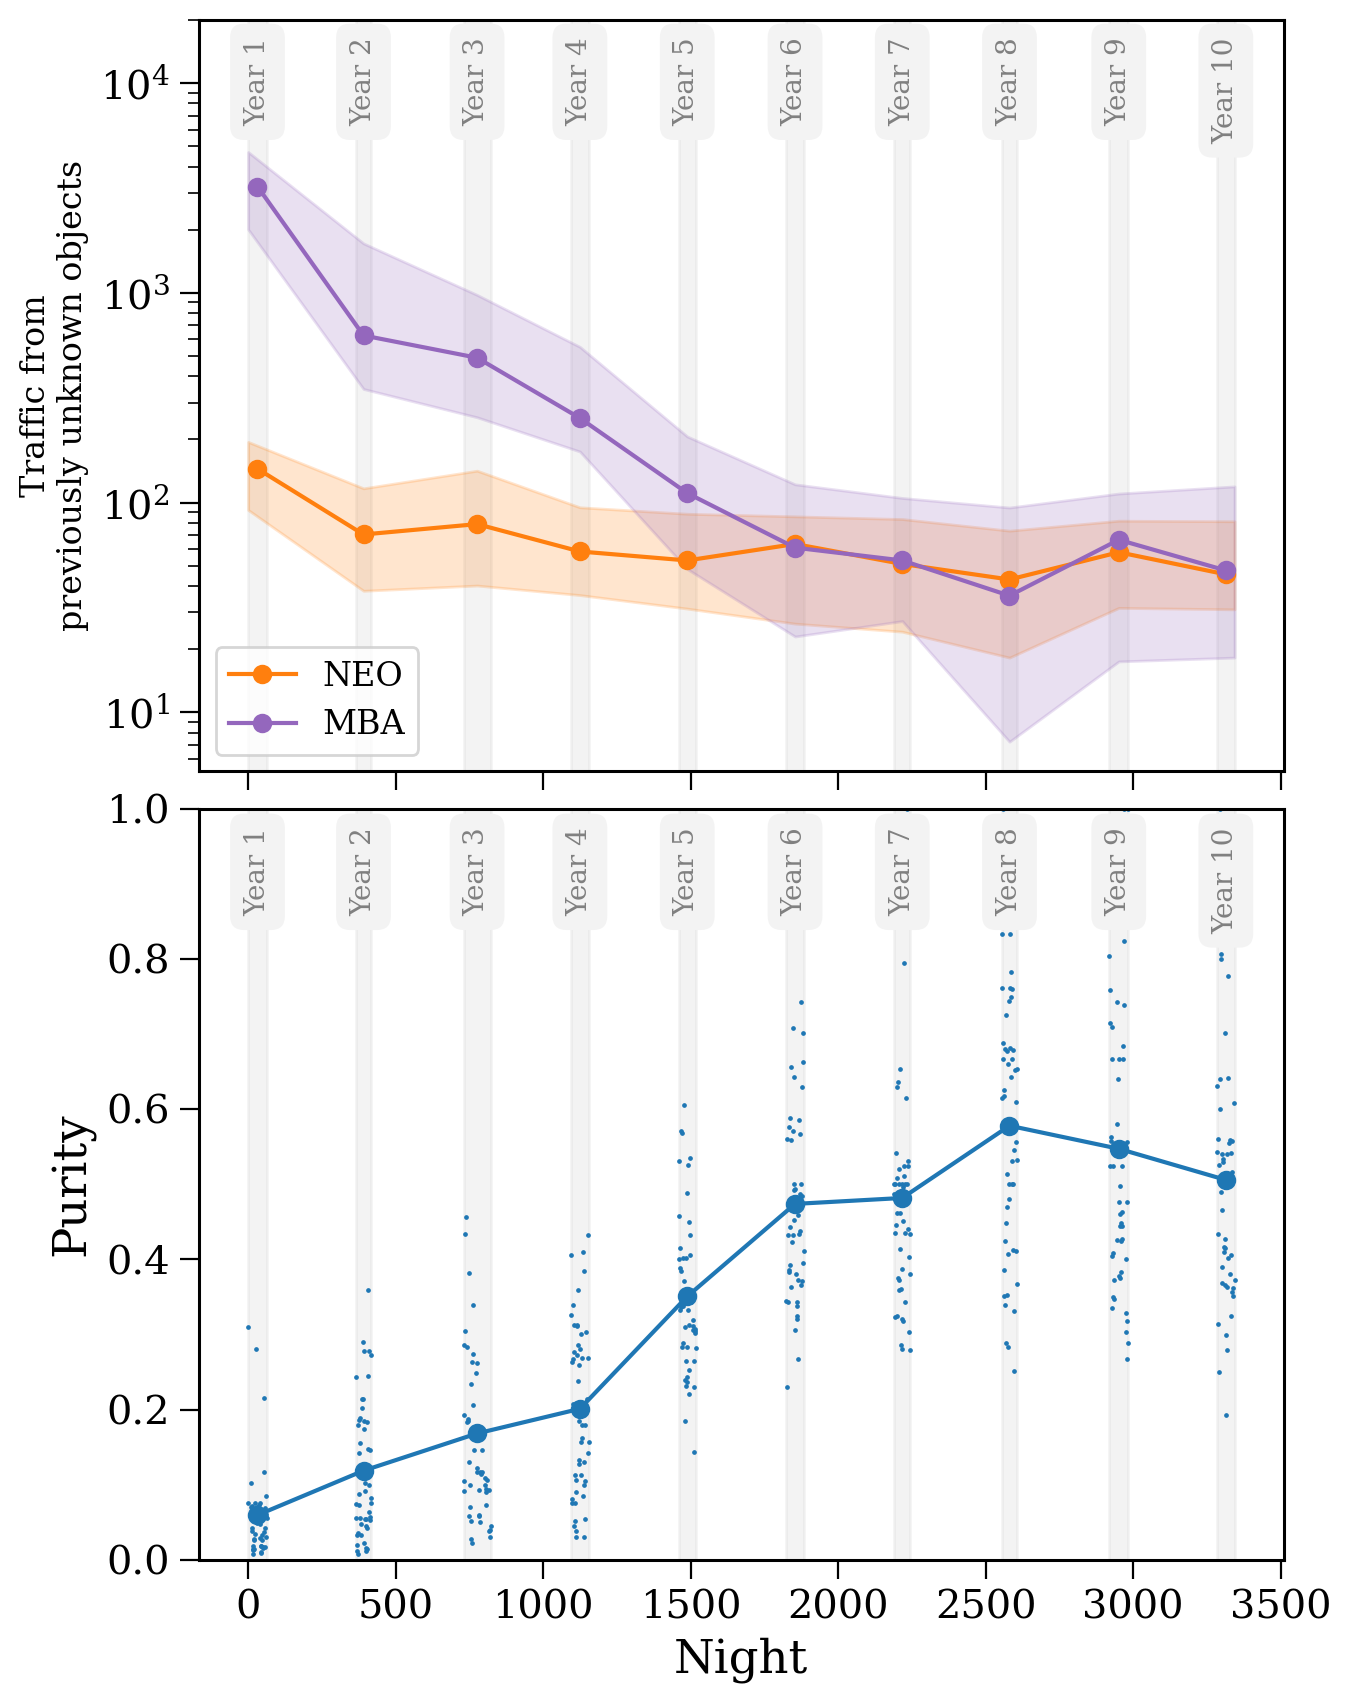

In [31]:
fig, axes = plt.subplots(2, 1, figsize=(7, 10), sharex=True)
fig.subplots_adjust(hspace=0.05)

for traffic, label, colour in zip([neo_traffics, mba_traffics],
                                  ["NEO", "MBA"],
                                  ["tab:orange", "tab:purple"]):
    percs = np.percentile(traffic, [25, 50, 75], axis=1)
    mid_times = years[:, 0] + (years[:, -1] - years[:, 0]) / 2
    axes[0].plot(mid_times, percs[1], marker="o", label=label, color=colour)
#     axes[1].plot(mid_times, np.max(traffic, axis=1), label=label, color=colour, linestyle="--")
    
    # adjust mid times to get area to play nicely
    mid_times[0] = years[0, 0]
    mid_times[-1] = years[-1, -1]
    axes[0].fill_between(mid_times, percs[0], percs[2], alpha=0.2, color=colour)

for ax, y_loc in zip(axes, [1.65e4, 0.975]):
    for i, night_list in enumerate(years, start=1):
        ax.axvspan(night_list[0], night_list[-1], color="lightgrey", alpha=0.25, zorder=-1)
        ax.annotate(f"Year {i}", xy=(night_list[0] + (night_list[-1] - night_list[0]) / 2, y_loc),
                    ha="center", va="top", rotation=90, color="grey",
                    bbox=dict(boxstyle="round", fc="#f3f3f3", ec="none", pad=0.5, zorder=-1))

axes[0].set_ylabel("Traffic from\npreviously unknown objects", fontsize=0.5*fs)
axes[0].set_yscale("log")
axes[0].set_ylim(top=2e4)
axes[0].legend(loc="lower left", fontsize=0.5*fs)

axes[1].scatter(np.ravel(years), np.ravel((neo_traffics / (neo_traffics + mba_traffics))), s=0.5)
axes[1].plot(years[:, 0] + (years[:, -1] - years[:, 0]) / 2,
           np.mean(neo_traffics / (neo_traffics + mba_traffics), axis=1),
           color="tab:blue", marker="o")

axes[1].set_ylabel("Purity", fontsize=0.7 * fs)
axes[1].set_ylim(0, 1)
axes[1].set_xlabel("Night", fontsize=0.7*fs)

plt.savefig("../paper/figures/digest2_purity_over_lsst.pdf", format="pdf", bbox_inches="tight")

plt.show()